In [1]:


import os
import sys
import math
import random
import itertools

sys.path.append('../oddsmaker/')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.style.use('ggplot')

from copy import copy
from tqdm import tqdm
from trueskill import TrueSkill, Rating, rate_1vs1


In [2]:

ratings = {
    'Alice':1900,
    'Bob':1700,
    'Chelsea':1500,
    'Dimitri':1300,
    'Evelyn':1100
}

class EloRating():
    def __init__(self, mu=1500):
        self.mu = mu
        self.games_played = 0

class EloMatch():
    def __init__(self, p1, p2, k=12):
        self.p1 = p1
        self.p2 = p2
        self.k = k
        
    def play_single_match(self, result):
        
        exp = 1/(1+10**((self.p2.mu-self.p1.mu)/400))
        mod = self.k*(result-exp)
        self.p1.mu +=mod
        self.p1.games_played+=1
        return self.p1
    
        
### Basic Elo Test ###
def run_elo_test(k=24, num_tests=5000, num_games_per_test=250):
    elo_test_data = []
    for test in tqdm(range(num_tests)):
        true_ratings = {
            'Alice':1900,
            'Bob':1700,
            'Chelsea':1500,
            'Dimitri':1300,
            'Evelyn':1100
        }
        players = {
            'Alice':EloRating(),
            'Bob':EloRating(),
            'Chelsea':EloRating(),
            'Dimitri':EloRating(),
            'Evelyn':EloRating()
        }
        player_list = list(players.keys())
        for game in range(num_games_per_test):
            ## randomly choose two players
            p1,p2 = random.sample(player_list, 2)
            p1_obj = players[p1]
            p2_obj = players[p2] 
            match_1 = EloMatch(p1_obj, p2_obj,k=k) 
            match_2 = EloMatch(p2_obj, p1_obj,k=k)

            p1_true = true_ratings[p1]
            p2_true = true_ratings[p2]

            prob = 1/(1+10**((p2_true-p1_true)/400))
            if np.random.random() < prob:
                result = 1
            else:
                result = 0

            p1_obj = players[p1]
            p2_obj = players[p2]

            elo_test_data.append([test+1, p1, p1_obj.games_played, p1_obj.mu])
            elo_test_data.append([test+1, p2, p2_obj.games_played, p2_obj.mu])

            p1_obj = match_1.play_single_match(result)
            p2_obj = match_2.play_single_match(1-result)

            players[p1] = p1_obj
            players[p2] = p2_obj

    elo_test_data = pd.DataFrame(elo_test_data, columns=['test_num','player','games_played','rating'])
    
    return elo_test_data

num_tests=5000
e12 = run_elo_test(k=12, num_tests=num_tests)
e24 = run_elo_test(k=24, num_tests=num_tests)
e36 = run_elo_test(k=36, num_tests=num_tests)



100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1032.35it/s]


In [3]:

e12.head()


,test_num,player,games_played,rating
0,1,Chelsea,0,1500.000000
1,1,Alice,0,1500.000000
2,1,Chelsea,1,1494.000000
3,1,Evelyn,0,1500.000000
4,1,Evelyn,1,1494.001789


### Elo sim graph
Takes a few minutes, but feel free to uncomment and run

In [4]:

colors = {
    'Alice':'#F82853',
    'Bob':'#F89701',
    'Chelsea':'#2DDE10',
    'Dimitri':'#01D5FA',
    'Evelyn':'#8153D0'
}

# fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# ax1 = axes[0]
# ax1.set_title('K = 12', fontsize=20)
# ax1.set_ylim(1000, 2000)
# ax1.hlines(ratings['Alice'], xmin=0, xmax=120, color=colors['Alice'],linewidth=3, linestyle='--',label='Alice')
# ax1.hlines(ratings['Bob'], xmin=0, xmax=120, color=colors['Bob'],linewidth=3, linestyle='--',label='Bob')
# ax1.hlines(ratings['Chelsea'], xmin=0, xmax=120, color=colors['Chelsea'],linewidth=3, linestyle='--', label='Chelsea')
# ax1.hlines(ratings['Dimitri'], xmin=0, xmax=120, color=colors['Dimitri'],linewidth=3, linestyle='--',label='Dimitri')
# ax1.hlines(ratings['Evelyn'], xmin=0, xmax=120, color=colors['Evelyn'],linewidth=3, linestyle='--',label='Evelyn')
# ax1.legend()
# ax1.set_ylabel("Rating")

# for test_num, test_data in e12.groupby('test_num'):
#     if test_num % 1000 == 0:
#         print("first_graph", test_num)
#     for player_name, player in test_data.groupby(['player']):
#         ax1.plot(player.games_played, player.rating, alpha=0.05, color=colors[player_name])

# ax2 = axes[1]
# ax2.set_title('K = 24', fontsize=20)
# ax2.set_ylim(1000, 2000)
# ax2.hlines(ratings['Alice'], xmin=0, xmax=120, color=colors['Alice'],linewidth=3, linestyle='--',label='Alice')
# ax2.hlines(ratings['Bob'], xmin=0, xmax=120, color=colors['Bob'],linewidth=3, linestyle='--',label='Bob')
# ax2.hlines(ratings['Chelsea'], xmin=0, xmax=120, color=colors['Chelsea'],linewidth=3, linestyle='--', label='Chelsea')
# ax2.hlines(ratings['Dimitri'], xmin=0, xmax=120, color=colors['Dimitri'],linewidth=3, linestyle='--',label='Dimitri')
# ax2.hlines(ratings['Evelyn'], xmin=0, xmax=120, color=colors['Evelyn'],linewidth=3, linestyle='--',label='Evelyn')
# ax2.legend()
# ax2.set_ylabel("Rating")

# for test_num, test_data in e24.groupby('test_num'):
#     if test_num % 1000 == 0:
#         print("second_graph", test_num)
#     for player_name, player in test_data.groupby(['player']):
#         ax2.plot(player.games_played, player.rating, alpha=0.05, color=colors[player_name])

# ax3 = axes[2]
# ax3.set_title('K = 36', fontsize=20)
# ax3.set_ylim(1000, 2000)
# ax3.hlines(ratings['Alice'], xmin=0, xmax=120, color=colors['Alice'],linewidth=3, linestyle='--',label='Alice')
# ax3.hlines(ratings['Bob'], xmin=0, xmax=120, color=colors['Bob'],linewidth=3, linestyle='--',label='Bob')
# ax3.hlines(ratings['Chelsea'], xmin=0, xmax=120, color=colors['Chelsea'],linewidth=3, linestyle='--', label='Chelsea')
# ax3.hlines(ratings['Dimitri'], xmin=0, xmax=120, color=colors['Dimitri'],linewidth=3, linestyle='--',label='Dimitri')
# ax3.hlines(ratings['Evelyn'], xmin=0, xmax=120, color=colors['Evelyn'],linewidth=3, linestyle='--',label='Evelyn')

# for test_num, test_data in e36.groupby('test_num'):
#     if test_num % 1000 == 0:
#         print("third_graph", test_num)
#     for player_name, player in test_data.groupby(['player']):
#         ax3.plot(player.games_played, player.rating, alpha=0.05, color=colors[player_name])

# ax3.set_xlabel("Game Number")
# ax3.set_ylabel("Rating")
# ax3.legend()
# plt.savefig('C://Users/Blake/Downloads/k_convergence.png', bbox_inches='tight')
# plt.show()


### Elo vs. Elo w/ Decay vs. Glicko vs. TrueSkill

In [5]:

## elo is simply elo 24

### Elo w/ Decaying K Test ###
def run_DK_elo_test(beginning_k=50, decay_rate=0.006931, num_tests=5000, num_games_per_test=250):
    elo_test_data = []
    for test in tqdm(range(num_tests)):
        true_ratings = {
            'Alice':1900,
            'Bob':1700,
            'Chelsea':1500,
            'Dimitri':1300,
            'Evelyn':1100
        }
        players = {
            'Alice':EloRating(),
            'Bob':EloRating(),
            'Chelsea':EloRating(),
            'Dimitri':EloRating(),
            'Evelyn':EloRating()
        }
        player_list = list(players.keys())
        for game in range(num_games_per_test):
            ## randomly choose two players
            p1,p2 = random.sample(player_list, 2)
            p1_obj = players[p1]
            p2_obj = players[p2] 
            
            dynamic_k = beginning_k * np.exp(-decay_rate*np.mean([p1_obj.games_played, p2_obj.games_played]))
            
            match_1 = EloMatch(p1_obj, p2_obj,k=dynamic_k) 
            match_2 = EloMatch(p2_obj, p1_obj,k=dynamic_k)

            p1_true = true_ratings[p1]
            p2_true = true_ratings[p2]

            prob = 1/(1+10**((p2_true-p1_true)/400))
            if np.random.random() < prob:
                result = 1
            else:
                result = 0

            p1_obj = players[p1]
            p2_obj = players[p2]

            elo_test_data.append([test+1, p1, p1_obj.games_played, p1_obj.mu])
            elo_test_data.append([test+1, p2, p2_obj.games_played, p2_obj.mu])

            p1_obj = match_1.play_single_match(result)
            p2_obj = match_2.play_single_match(1-result)

            players[p1] = p1_obj
            players[p2] = p2_obj

    elo_test_data = pd.DataFrame(elo_test_data, columns=['test_num','player','games_played','rating'])
    
    return elo_test_data

dynamic_k = run_DK_elo_test()


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:12<00:00, 411.92it/s]


In [6]:


from copy import deepcopy

MU = 1500
RD = 350
MAX_RD = 350

## time between games
## going small, don't want it to affect
C = 1

class GlickoRating():
    
    def __init__(self,mu=MU, rd=350, max_RD =350, time_off_factor=1):
        
        self.mu=mu
        self.rd=rd
        self.max_rd=max_RD
        self.games_played = 0
        self.time_off_factor = time_off_factor
        
        return
    
    def prep(self,time_off=1):
        
        ## update RD for time off
        self.rd =np.min([np.sqrt(self.rd**2+(self.time_off_factor*time_off)**2),self.max_rd])
        
        return
    
    
    
class GlickoMatch():
    
    """
    Input two glicko objects. Returns modified objects based on result.
    Result can be randomly generated or provided
    
    """
    
    def __init__(self, player_a, player_a_time_off, player_b, player_b_time_off, 
                 q=np.log(10)/400
                ):
        
        self.player_a = deepcopy(player_a)
        self.a_time_off = player_a_time_off
        self.player_b = deepcopy(player_b)
        self.b_time_off = player_b_time_off
        
        self.q = q
        return
    
    def play_single_match(self, result):
        
        
        
        self.player_a.prep(self.a_time_off)
        self.player_b.prep(self.b_time_off)
        
        self.g_opp = 1/np.sqrt((1+(3*self.q**2)*(self.player_b.rd**2)/np.pi**2))
        
        exp_res = 1/(1+10**((-self.g_opp*(self.player_a.mu-self.player_b.mu))/400))
        d_sq = 1/(self.q**2 * self.g_opp**2*(exp_res)*(1-exp_res))
        
        
        self.player_a.mu = self.player_a.mu + (self.q/(1/self.player_a.rd**2+1/d_sq)*self.g_opp*(result-exp_res))
        self.player_a.rd = np.sqrt(1/(1/self.player_a.rd**2 + 1/d_sq))
        self.player_a.games_played+=1
        
        return self.player_a
    
    
class GlickoMatches():
    
    """
    Input two glicko objects. Returns modified objects based on result.
    Result can be randomly generated or provided
    
    """
    
    def __init__(self, player_a, player_a_time_off, opponents, opp_times_off, 
                 q=np.log(10)/400
                ):
        
        self.player_a = deepcopy(player_a)
        self.a_time_off = player_a_time_off
        assert(type(opponents)==list)
        assert(type(opp_times_off)==list)
        assert(len(opponents)==len(opp_times_off))
        self.opponents = deepcopy(opponents)
        self.num_opps = len(self.opponents)
        self.opp_times_off = opp_times_off
        
        
        self.q = q
        return
    
    def play_rating_period(self, results):
        
        assert(type(results)==list)

        self.player_a.prep(self.a_time_off)

        for i, opp in enumerate(self.opponents):
            opp.prep(self.opp_times_off[i])
        
        g_opps = []
        for opp in self.opponents:
            g_opp = 1/np.sqrt((1+(3*self.q**2)*(opp.rd**2)/np.pi**2))
            g_opps.append(g_opp)
            
        print(g_opps)
        exp_results = []
        for i, opp in enumerate(self.opponents):
            exp_res = 1/(1+10**((-g_opps[i]*(self.player_a.mu-opp.mu))/400))
            exp_results.append(exp_res)
            
        print(exp_results)
        d_sq = 1/(self.q**2 * np.sum([g_opps[i]**2*(exp_results[i])*(1-exp_results[i]) for i in range(self.num_opps)]))
        print(d_sq)
        
        self.player_a.mu = self.player_a.mu + (self.q/(1/self.player_a.rd**2+1/d_sq)*np.sum([g_opps[i]*(results[i]-exp_results[i]) for i in range(self.num_opps)]))
        self.player_a.rd = np.sqrt(1/(1/self.player_a.rd**2 + 1/d_sq))
        
        
        print(self.player_a.mu, self.player_a.rd)
        return self.player_a


    


### Glicko Test ###
num_tests = 5000
num_games_per_test = 250


def initialize_players():
    glicko_players = {
        'Alice':GlickoRating(),
        'Bob':GlickoRating(),
        'Chelsea':GlickoRating(),
        'Dimitri':GlickoRating(),
        'Evelyn':GlickoRating()
    }
    
    ratings_map = {
        'Alice':1900,
        'Bob':1700,
        'Chelsea':1500,
        'Dimitri':1300,
        'Evelyn':1100
    }
    
    return glicko_players, ratings_map

### test convergence ###
test_data = []
for test in tqdm(range(num_tests)):
    players, true_ratings = initialize_players()
    player_list = list(players.keys())
    for game in range(num_games_per_test):
        
        ## randomly choose two players
        p1,p2 = random.sample(player_list, 2)
        p1_obj = players[p1]
        p2_obj = players[p2] 
        
        match_1 = GlickoMatch(p1_obj, 0, p2_obj, 0)
        match_2 = GlickoMatch(p2_obj, 0, p1_obj, 0)
        
        p1_true = true_ratings[p1]
        p2_true = true_ratings[p2]
        
        prob = 1/(1+10**((p2_true-p1_true)/400))
        if np.random.random() < prob:
            result = 1
        else:
            result = 0
            
        test_data.append([test+1, p1, p1_obj.games_played, p1_obj.mu, p1_obj.rd])
        test_data.append([test+1, p2, p2_obj.games_played, p2_obj.mu, p2_obj.rd])
            
        p1_obj = match_1.play_single_match(result)
        p2_obj = match_2.play_single_match(1-result)
        
        players[p1] = p1_obj
        players[p2] = p2_obj
        
test_data = pd.DataFrame(test_data, columns=['test_num','player','games_played','rating','rd'])


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:08<00:00, 73.40it/s]


In [7]:

### TrueSkill test
num_tests = 5000
num_games_per_test = 250

MU = 1500
#: Default initial standard deviation of ratings.
SIGMA = MU / 3.5
#: Default distance that guarantees about 76% chance of winning.
BETA = SIGMA / 2
#: Default dynamic factor.
TAU = SIGMA / 100
DRAW_PROBABILITY = 0

env = TrueSkill(mu=MU, sigma=SIGMA, beta=BETA, tau=TAU, draw_probability=DRAW_PROBABILITY)
env.make_as_global() 

def win_probability(team1, team2):
    delta_mu = sum(r.mu for r in team1) - sum(r.mu for r in team2)
    sum_sigma = sum(r.sigma ** 2 for r in itertools.chain(team1, team2))
    size = len(team1) + len(team2)
    denom = math.sqrt(size * (BETA * BETA) + sum_sigma)
    ts = trueskill.global_env()
    return ts.cdf(delta_mu / denom)


def initialize_players():
    TS_players = {
        'Alice':env.create_rating(),
        'Bob':env.create_rating(),
        'Chelsea':env.create_rating(),
        'Dimitri':env.create_rating(),
        'Evelyn':env.create_rating()
    }
    
    ratings_map = {
        'Alice':1900,
        'Bob':1700,
        'Chelsea':1500,
        'Dimitri':1300,
        'Evelyn':1100
    }
    
    return TS_players, ratings_map

### test convergence ###
TS_test_data = []
for test in tqdm(range(num_tests)):
    players, true_ratings = initialize_players()
    player_list = list(players.keys())
    
    gp_count = {
        'Alice':0,
        'Bob':0,
        'Chelsea':0,
        'Dimitri':0,
        'Evelyn':0
    }
    
    for game in range(num_games_per_test):
        
        ## randomly choose two players
        p1,p2 = random.sample(player_list, 2)
        p1_obj = players[p1]
        p2_obj = players[p2] 
        
        p1_true = true_ratings[p1]
        p2_true = true_ratings[p2]
        
        TS_test_data.append([test+1, p1, gp_count[p1], p1_obj.mu, p1_obj.sigma])
        TS_test_data.append([test+1, p2, gp_count[p2], p2_obj.mu, p2_obj.sigma])
        
        gp_count[p1] +=1
        gp_count[p2] +=1
        
        prob = 1/(1+10**((p2_true-p1_true)/400))
        if np.random.random() < prob:
            new_p1, new_p2 = rate_1vs1(p1_obj, p2_obj)
        else:
            new_p2, new_p1 = rate_1vs1(p2_obj, p1_obj)
        
        players[p1] = new_p1
        players[p2] = new_p2
        
TS_test_data = pd.DataFrame(TS_test_data, columns=['test_num','player','games_played','rating','rd'])



100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:14<00:00, 37.29it/s]


In [8]:
alice_elo = e24.loc[e24['player']=='Alice'].copy().groupby(['games_played'])['rating'].mean().reset_index()
alice_elo.columns=['games_played','avg_rating']
alice_elo = alice_elo.loc[alice_elo['games_played']<=110].reset_index(drop=True)

alice_elo_DK = dynamic_k.loc[dynamic_k['player']=='Alice'].copy().groupby(['games_played'])['rating'].mean().reset_index()
alice_elo_DK.columns=['games_played','avg_rating']
alice_elo_DK = alice_elo_DK.loc[alice_elo_DK['games_played']<=110].reset_index(drop=True)

alice_glicko = test_data.loc[test_data['player']=='Alice'].copy().groupby(['games_played'])['rating'].mean().reset_index()
alice_glicko.columns=['games_played','avg_rating']
alice_glicko = alice_glicko.loc[alice_glicko['games_played']<=110].reset_index(drop=True)

alice_TS = TS_test_data.loc[TS_test_data['player']=='Alice'].copy().groupby(['games_played'])['rating'].mean().reset_index()
alice_TS.columns=['games_played','avg_rating']
alice_TS = alice_TS.loc[alice_TS['games_played']<=110].reset_index(drop=True)


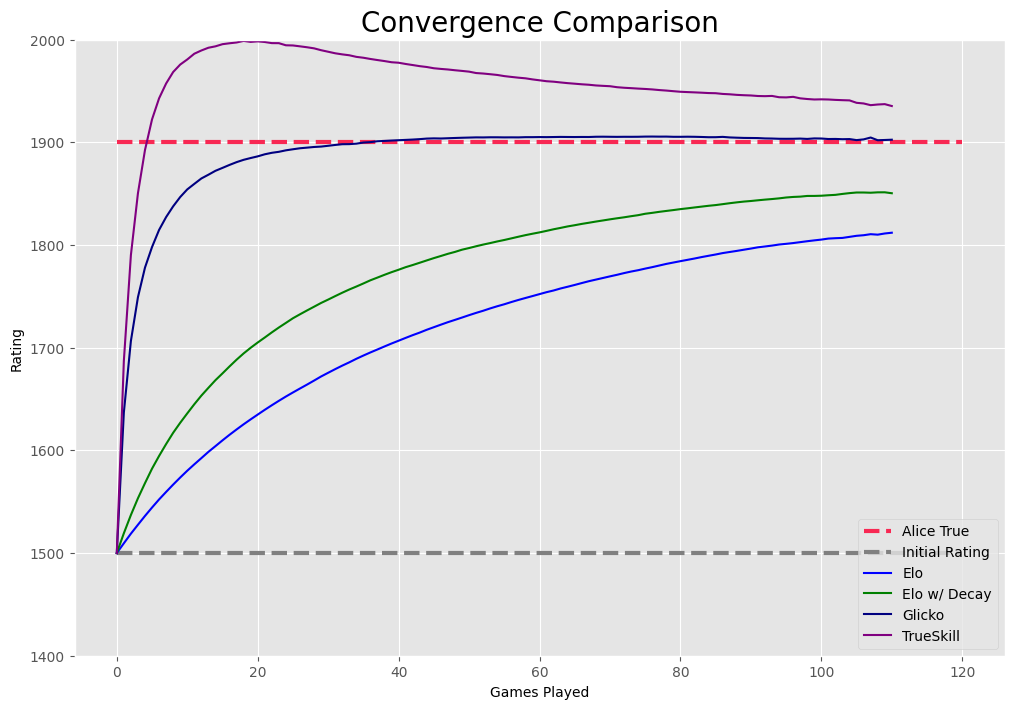

In [9]:

fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True)

# ax1 = axes[0]
ax.set_title('Convergence Comparison', fontsize=20)
ax.set_ylim(1400, 2000)
ax.hlines(ratings['Alice'], xmin=0, xmax=120, color=colors['Alice'],linewidth=3, linestyle='--',label='Alice True')
ax.hlines(1500, xmin=0, xmax=120, color='grey',linewidth=3, linestyle='--',label='Initial Rating')

ax.set_ylabel("Rating")

ax.plot(alice_elo.games_played, alice_elo.avg_rating, label='Elo', color='blue')
ax.plot(alice_elo_DK.games_played, alice_elo_DK.avg_rating, label='Elo w/ Decay', color='green')
ax.plot(alice_glicko.games_played, alice_glicko.avg_rating, label='Glicko', color='navy')
ax.plot(alice_TS.games_played, alice_TS.avg_rating, label='TrueSkill', color='purple')

ax.set_xlabel("Games Played")
# for test_num, test_data in dynamic_k.groupby('test_num'):
#     if test_num % 1000 == 0:
#         print("first_graph", test_num)
#     for player_name, player in test_data.groupby(['player']):
#         ax1.plot(player.games_played, player.rating, alpha=0.05, color=colors[player_name])

ax.legend()
plt.savefig('C://Users/Blake/Downloads/rating_systems_convergence.png', bbox_inches='tight')
plt.show()



- create normally distributed sample of 10000 players
- select two random ones
- call it "blue player" and "red player"


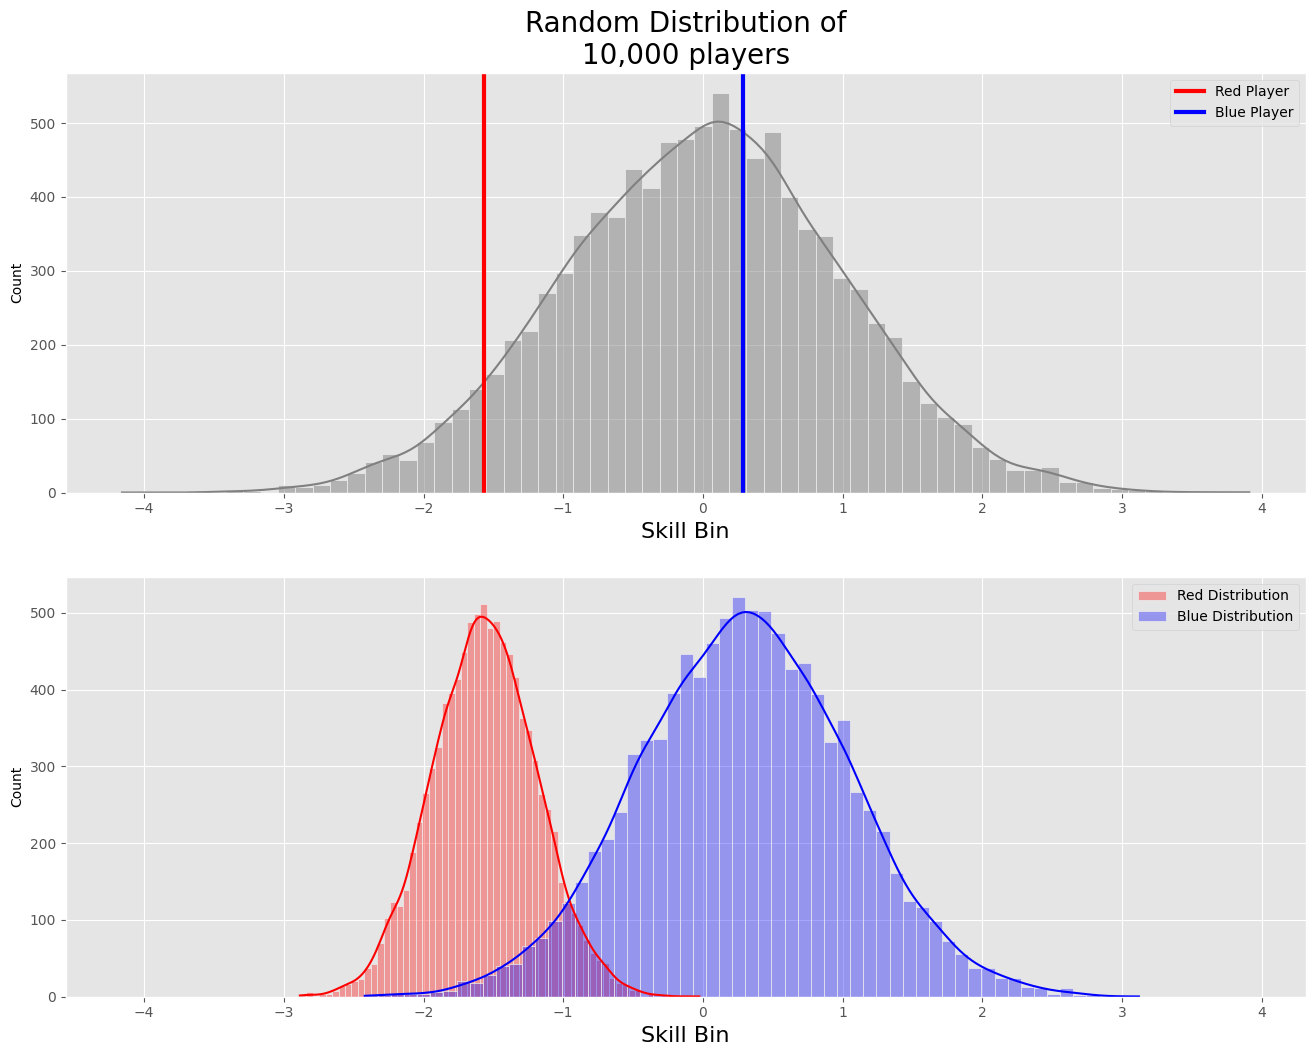

In [10]:


random_distribution = list(np.random.normal(0, 1, 10000))

fig, axes = plt.subplots(2, 1, figsize=(16, 12))
ax1 = axes[0]
ax2 = axes[1]
blue_player = random.sample(random_distribution,1)
red_player = random.sample(random_distribution,1)
red_player=-1.5638447592871616
blue_player=0.2886639240423845
blue_stdev = 0.75
red_stdev = 0.375

ax1.set_title('Random Distribution of\n10,000 players', fontsize=20)
sns.histplot(random_distribution, ax=ax1, color = 'grey', kde=True)
ax1.axvline(red_player, color='red', label='Red Player', lw=3)
ax1.axvline(blue_player, color='blue', label='Blue Player', lw=3)
ax1.set_xlabel('Skill Bin',fontsize=16)
ax1.legend()

blue_player_dist = np.random.normal(blue_player, blue_stdev, 10000)
red_player_dist = np.random.normal(red_player, red_stdev, 10000)
sns.histplot(red_player_dist, ax=ax2, color = 'red', alpha=0.35, kde=True, label='Red Distribution')
sns.histplot(blue_player_dist, ax=ax2, color = 'blue', alpha=0.35, kde=True, label='Blue Distribution')

ax2.set_xlabel('Skill Bin',fontsize=16)
ax2.set_xlim(ax1.get_xlim())

ax2.legend()
plt.savefig('C://Users/Blake/Downloads/medium_uncertain_1.png')
plt.show()


In [11]:

print(red_player, blue_player, red_stdev, blue_stdev)


-1.5638447592871616 0.2886639240423845 0.375 0.75



- coming up with distribution of their skill differences


In [12]:

mean_z = blue_player-red_player
stdev_z = np.sqrt(red_stdev**2+blue_stdev**2)

def sigmoid(x):
    return 1/(1+np.exp(-x))


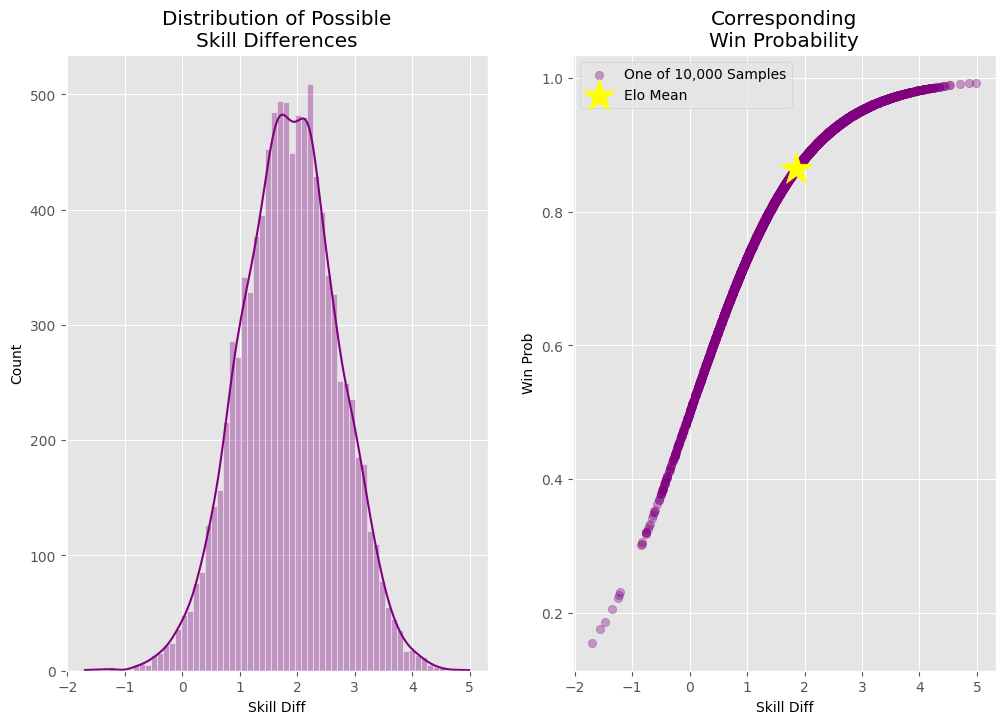

In [13]:

fig, axes = plt.subplots(1,2, figsize=(12,8))
left_ax = axes[0]
right_ax = axes[1]
z_dist = np.random.normal(mean_z, stdev_z, 10000)
probs_z = sigmoid(z_dist)
left_ax.set_title('Distribution of Possible\nSkill Differences')
left_ax.set_xlabel('Skill Diff')
right_ax.set_title('Corresponding\nWin Probability')
right_ax.set_xlabel('Skill Diff')
right_ax.set_ylabel('Win Prob')
sns.histplot(z_dist, ax=left_ax, color = 'purple', alpha=0.35, kde=True, label='Purple Distribution')
right_ax.scatter(z_dist, probs_z, color='purple', alpha=0.35, label='One of 10,000 Samples')
right_ax.scatter(np.array(mean_z), sigmoid(np.array(mean_z)), color='yellow', marker='*', s=600, label='Elo Mean')
right_ax.legend()
right_ax.set_xlim(left_ax.get_xlim())
plt.savefig('C://Users/Blake/Downloads/medium_uncertain_3.png')
plt.show()


In [14]:

### generate data ###
ratings = {
    'A':1900,
    'B':1700,
    'C':1500,
    'D':1300,
    'E':1100
}

prob_table = []
for player_1, rating_1 in ratings.items():
    for player_2, rating_2 in ratings.items():
        if player_1 == player_2:
            prob_table.append([player_1, player_2, np.nan])
            continue
        rd = rating_2-rating_1
        prob = 1/(1+10**(rd/400))
        prob_table.append([player_1, player_2, prob])
        
prob_table = pd.DataFrame(prob_table, columns=['player_1','player_2','prob'])


test = prob_table.pivot(index='player_1', columns=['player_2'], values='prob')
test


player_2,A,B,C,D,E
player_1,,,,,
A,NaN,0.759747,0.909091,0.969347,0.990099
B,0.240253,NaN,0.759747,0.909091,0.969347
C,0.090909,0.240253,NaN,0.759747,0.909091
D,0.030653,0.090909,0.240253,NaN,0.759747
E,0.009901,0.030653,0.090909,0.240253,NaN


### Symbolic regression time

In [15]:

n1 = np.random.normal(mean_z,stdev_z,5000)
b1 = 1/(1+np.exp(-1*n1))

n2 = np.random.normal(mean_z,stdev_z*0.5,5000)
b2 = 1/(1+np.exp(-1*n2))

n3 = np.random.normal(mean_z,stdev_z*2,5000)
b3 = 1/(1+np.exp(-1*n3))


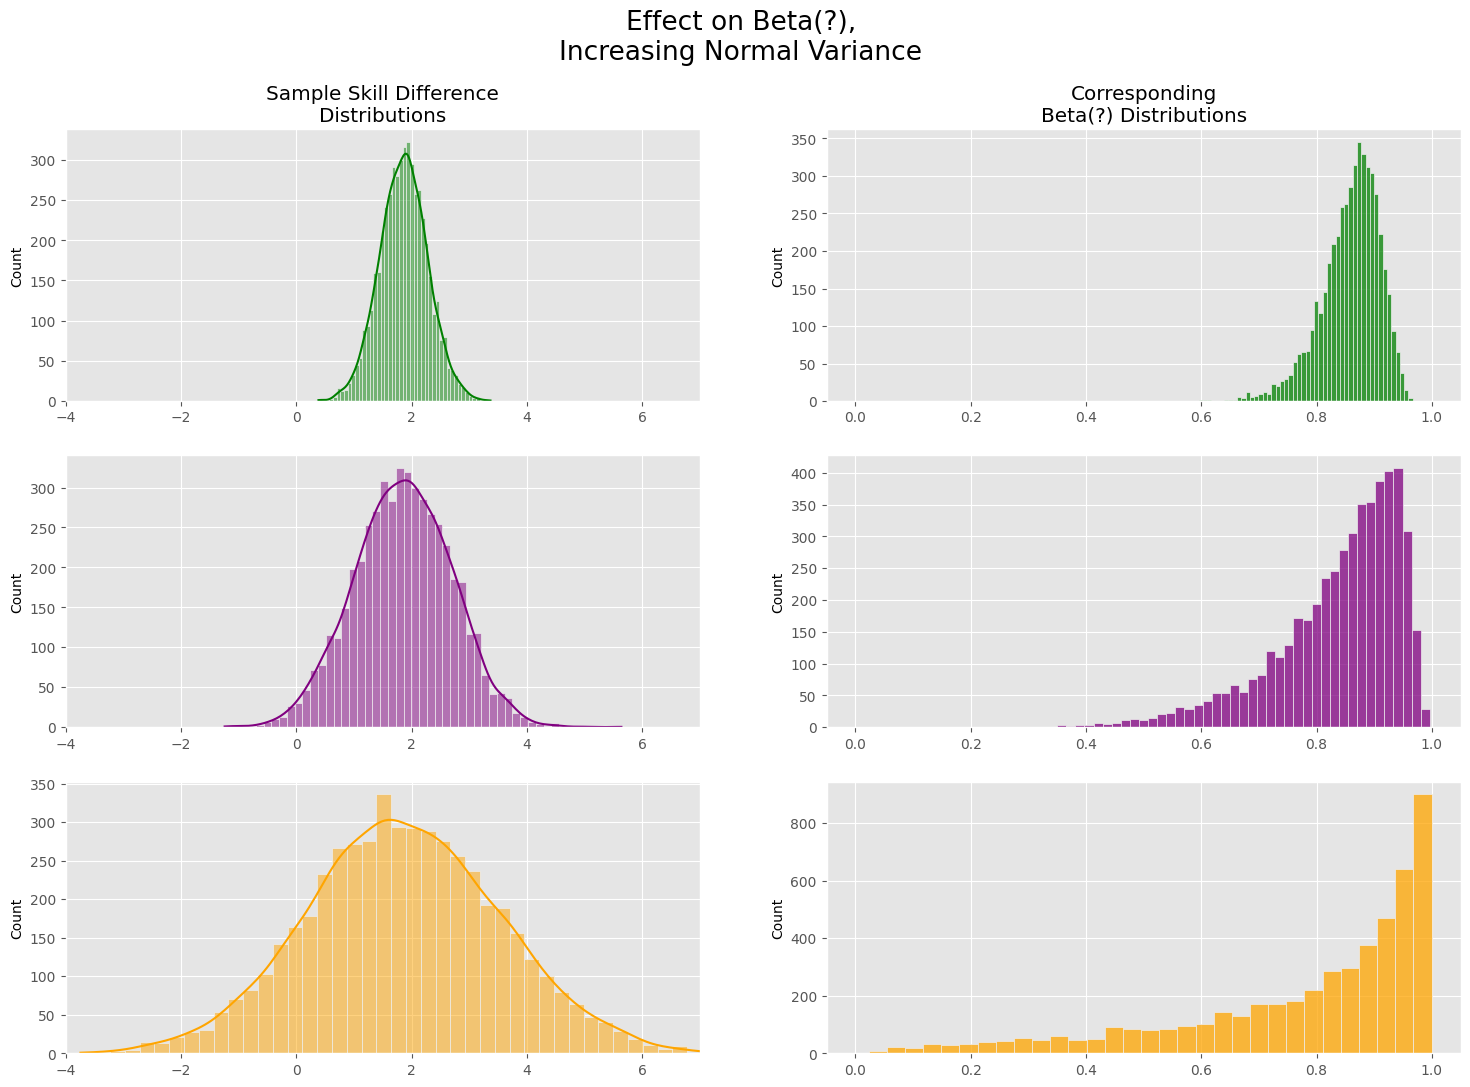

In [16]:

fig, axes = plt.subplots(3,2,figsize=(18,12))
plt.suptitle('Effect on Beta(?),\nIncreasing Normal Variance',fontsize=19)
ax_0_0 = axes[0][0]
ax_0_1 = axes[0][1]
sns.histplot(n2,  kde=True, ax=ax_0_0, color='green')
sns.histplot(b2,  ax=ax_0_1, color='green')
ax_0_0.set_title("Sample Skill Difference\nDistributions")
ax_0_1.set_title("Corresponding\nBeta(?) Distributions")
ax_0_0.set_xlim((-4,7))
ax_0_1.set_xlim((-0.05, 1.05))

ax_1_0 = axes[1][0]
ax_1_1 = axes[1][1]
sns.histplot(n1,  kde=True, ax=ax_1_0, color='purple')
sns.histplot(b1,  ax=ax_1_1, color='purple')
ax_1_0.set_xlim((-4,7))
ax_1_1.set_xlim((-0.05, 1.05))

ax_2_0 = axes[2][0]
ax_2_1 = axes[2][1]
sns.histplot(n3,  kde=True, ax=ax_2_0, color='orange')
sns.histplot(b3,  ax=ax_2_1, color='orange')
ax_2_0.set_xlim((-4,7))
ax_2_1.set_xlim((-0.05, 1.05))
plt.savefig('C://Users/Blake/Downloads/normal_to_beta.png', bbox_inches='tight')
plt.show()


In [17]:

from scipy.stats import beta
from scipy.optimize import minimize

# define the negative log likelihood function
def negative_log_likelihood(params, data):
    """ Negative log-likelihood. """
    # the `...` should be replaced with the beta distribution's log PDF expression
    return -np.sum(beta.logpdf(data, params[0], params[1]))

def get_beta_MLE(data):
    
    initial_params = [1, 1]

    # minimize the negative log likelihood
    results = minimize(negative_log_likelihood, initial_params, args=(data,), method='Nelder-Mead')

    # estimated alpha and beta
    alpha_hat, beta_hat = results.x
    
    return alpha_hat, beta_hat


alpha_1, beta_1 = get_beta_MLE(b1)
alpha_2, beta_2 = get_beta_MLE(b2)
alpha_3, beta_3 = get_beta_MLE(b3)




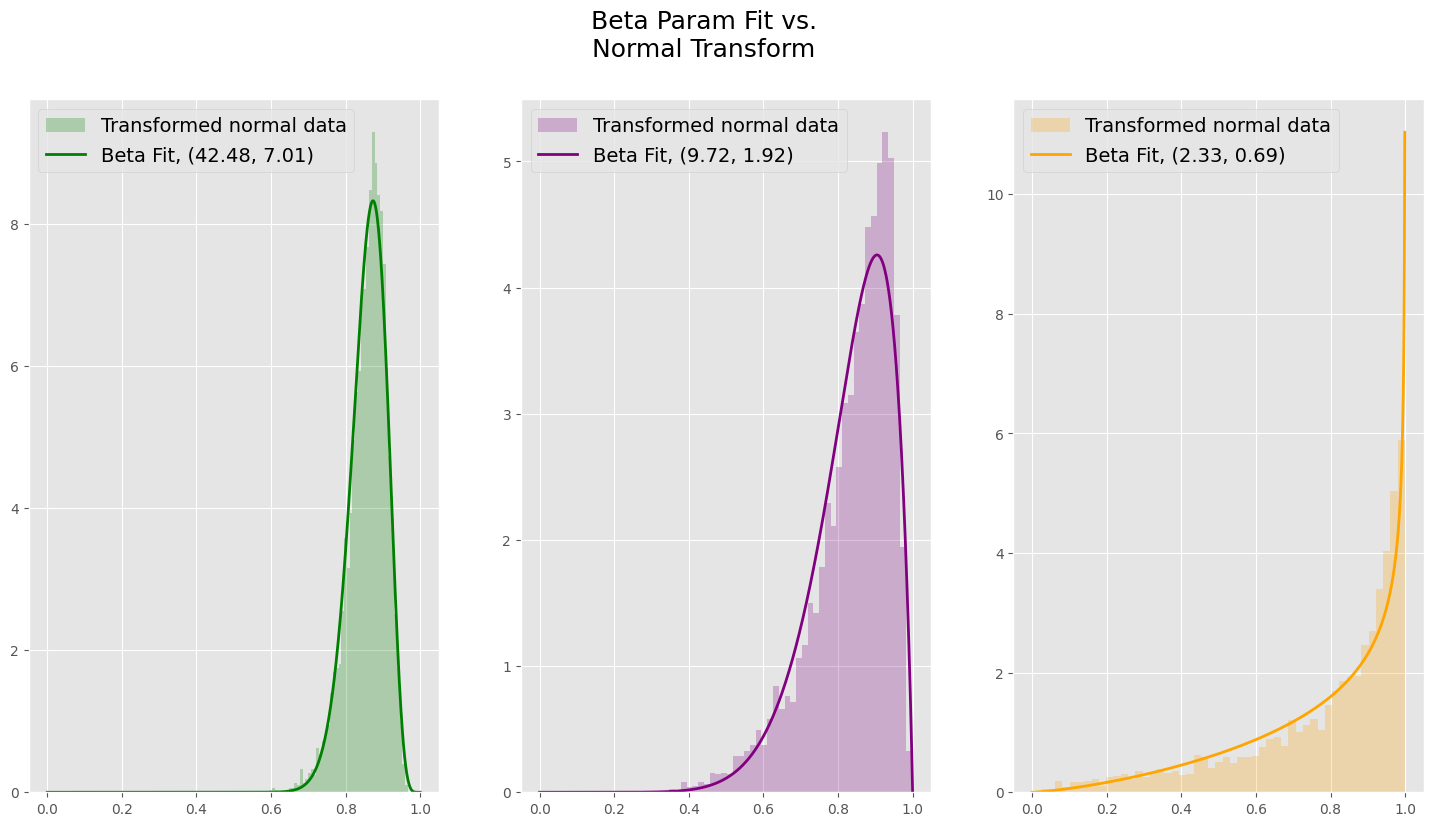

In [18]:



fig, axes = plt.subplots(1,3,figsize=(18,9))
ax0 = axes[0]
ax1 = axes[1]
ax2 = axes[2]
# Create histogram of your data
ax0.hist(b2, bins=50, density=True, label='Transformed normal data', alpha=0.25, color='green')

# Create a range of x values from 0 to 1 for the PDF
x = np.linspace(0, 1, 1000)

# Generate the y values by plugging the x values into the pdf of your estimated beta distribution
y = beta.pdf(x, alpha_2, beta_2)

# Plot the estimated Beta distribution
ax0.plot(x, y, lw=2, label=f'Beta Fit, ({alpha_2:.2f}, {beta_2:.2f})', color='green')

ax0.legend(fontsize=14)

# Create histogram of your data
ax1.hist(b1, bins=50, density=True, label='Transformed normal data', alpha=0.25, color='purple')

# Create a range of x values from 0 to 1 for the PDF
x = np.linspace(0, 1, 1000)

# Generate the y values by plugging the x values into the pdf of your estimated beta distribution
y = beta.pdf(x, alpha_1, beta_1)

# Plot the estimated Beta distribution
ax1.plot(x, y, lw=2, label=f'Beta Fit, ({alpha_1:.2f}, {beta_1:.2f})', color='purple')

ax1.legend(fontsize=14)

# Create histogram of your data
ax2.hist(b3, bins=50, density=True, label='Transformed normal data', alpha=0.25, color='orange')

# Create a range of x values from 0 to 1 for the PDF
x = np.linspace(0, 1, 1000)

# Generate the y values by plugging the x values into the pdf of your estimated beta distribution
y = beta.pdf(x, alpha_3, beta_3)

# Plot the estimated Beta distribution
ax2.plot(x, y, lw=2, label=f'Beta Fit, ({alpha_3:.2f}, {beta_3:.2f})', color='orange')

ax2.legend(fontsize=14)

plt.suptitle("Beta Param Fit vs.\nNormal Transform", fontsize=18)

plt.savefig('C://Users/Blake/Downloads/beta_fits.png', bbox_inches='tight')
plt.show()



In [19]:
# (inv(x0) / (x1 - (x0 * x1)))
def approx(beta_mu, var):
    return 1/((var - (beta_mu*var))*beta_mu)

sample = approx(sigmoid(mean_z),stdev_z**2)
sigmoid(mean_z)*sample


10.490018595981656

In [20]:
# (inv(x0 - (x0 * x0)) / x1) 
def approx_2(beta_mu, var):
    return  (1/((beta_mu-beta_mu**2)*var))
sample = approx_2(sigmoid(mean_z),stdev_z**2)
sigmoid(mean_z)*sample


10.490018595981665

In [21]:

sample = approx_2(sigmoid(mean_z),(stdev_z*0.5)**2)
sigmoid(mean_z)*sample, sample - sigmoid(mean_z)*sample


(41.96007438392666, 6.581152440477275)

In [22]:

sample = approx_2(sigmoid(mean_z),(stdev_z*2)**2)
sigmoid(mean_z)*sample, sample - sigmoid(mean_z)*sample


(2.6225046489954162, 0.4113220275298297)

In [23]:


### generate many distributions
std_devs = np.random.random(2500)*4+0.05
std_devs[std_devs<0.05] = 0.05
vars_ = std_devs**2
means = np.random.normal(0,3,2500)

beta_mus = 1/(1+np.exp(-1*means))
from pysr import PySRRegressor

X = np.stack([beta_mus, vars_]).T
y = []
for i  in tqdm(range(len(means)), total=len(means)):
    n_dist = np.random.normal(means[i], std_devs[i], 2500)
    b_dist = 1/(1+np.exp(-1*n_dist))
    a, b = get_beta_MLE(b_dist) 
    y.append(a+b)

preds = approx_2(X[:,0], X[:,1])
y_copy = copy(y)


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:44<00:00, 56.80it/s]


In [24]:

# X = np.stack([beta_mus, vars_]).T
# y = []
# for i  in tqdm(range(len(means)), total=len(means)):
#     n_dist = np.random.normal(means[i], std_devs[i], 2500)
#     b_dist = 1/(1+np.exp(-1*n_dist))
#     speed_test = approx_2(means[i], std_devs[i]**2)
#     y.append(a+b)



In [25]:

model = PySRRegressor(
    niterations=250, 
    binary_operators=["+", "*","-","/","^"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
        "sqrt",
        "inv(x) = 1/x",
        "abs"
        # ^ Custom operator (julia syntax)
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
)

model.fit(X,y)



C:\Users\Blake\anaconda3\lib\site-packages\pysr\sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                           453.1129   
	1         0.000040                                            inv(x0)   
	2         0.004654                                   (2154.0276 ^ x0)   
	3         0.013875                                     (inv(x1) / x0)   
	4         0.098475                                 inv(sqrt(x0) - x0)   
	5         3.744367                                inv(x1 - (x1 * x0))   
	6         0.298229                           inv(x0 - (x0 ^ exp(x1)))   
	7         2.794644                  (inv(x0 - (x0 ^ 2.0108576)) / x1)   
	8         0.000008             (inv(sin(x0 - (x0 ^ 2.0108576))) / x1)   
	9         0.659478           (inv(x0 - (x0 ^ (1.9648083 + x1))) / x1)   
	10        0.063096      (abs(inv((x0 ^ (1.9674683 + x1)) - x0)) / x1)   
	11  >>>>  1.293269    (inv((x0 - (x0 * x0)) / (0.6875573 ^ x1)) / x1)   
	12      

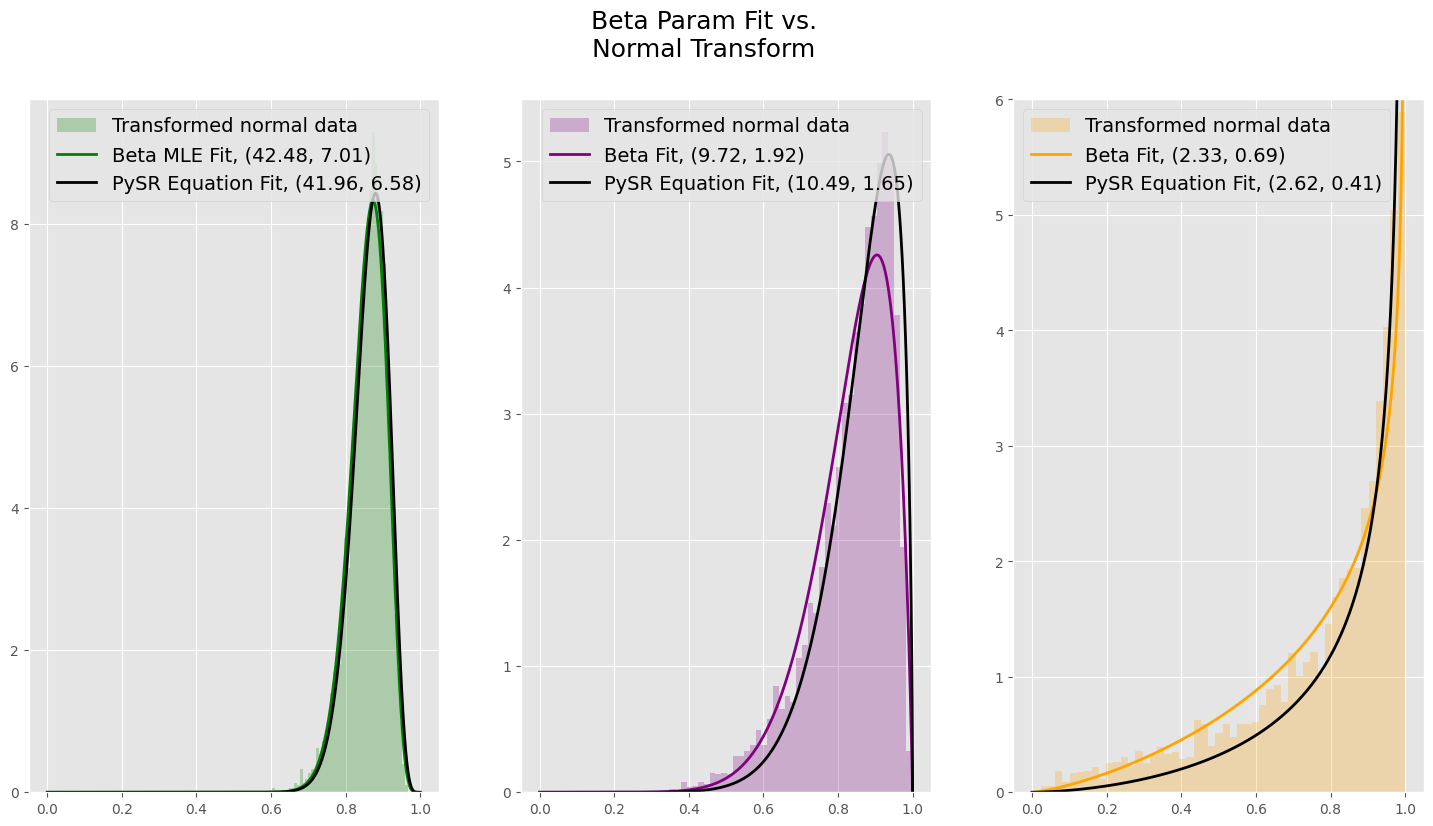

In [26]:

fig, axes = plt.subplots(1,3,figsize=(18,9))
ax0 = axes[0]
ax1 = axes[1]
ax2 = axes[2]
# Create histogram of your data
ax0.hist(b2, bins=50, density=True, label='Transformed normal data', alpha=0.25, color='green')

# Create a range of x values from 0 to 1 for the PDF
x = np.linspace(0, 1, 1000)

# Generate the y values by plugging the x values into the pdf of your estimated beta distribution
y = beta.pdf(x, alpha_2, beta_2)
sample = approx_2(sigmoid(mean_z),(stdev_z*0.5)**2)
alpha_fit_2, beta_fit_2 = sigmoid(mean_z)*sample, sample - sigmoid(mean_z)*sample
y2 = beta.pdf(x, alpha_fit_2, beta_fit_2)
# Plot the estimated Beta distribution
ax0.plot(x, y, lw=2, label=f'Beta MLE Fit, ({alpha_2:.2f}, {beta_2:.2f})', color='green')
ax0.plot(x, y2, lw=2, label=f'PySR Equation Fit, ({alpha_fit_2:.2f}, {beta_fit_2:.2f})', color='black')
ax0.legend(fontsize=14)

# Create histogram of your data
ax1.hist(b1, bins=50, density=True, label='Transformed normal data', alpha=0.25, color='purple')

# Create a range of x values from 0 to 1 for the PDF
x = np.linspace(0, 1, 1000)

# Generate the y values by plugging the x values into the pdf of your estimated beta distribution
y = beta.pdf(x, alpha_1, beta_1)
sample = approx_2(sigmoid(mean_z),(stdev_z)**2)
alpha_fit_2, beta_fit_2 = sigmoid(mean_z)*sample, sample - sigmoid(mean_z)*sample
y2 = beta.pdf(x, alpha_fit_2, beta_fit_2)

# Plot the estimated Beta distribution
ax1.plot(x, y, lw=2, label=f'Beta Fit, ({alpha_1:.2f}, {beta_1:.2f})', color='purple')
ax1.plot(x, y2, lw=2, label=f'PySR Equation Fit, ({alpha_fit_2:.2f}, {beta_fit_2:.2f})', color='black')
ax1.legend(fontsize=14)

# Create histogram of your data
ax2.hist(b3, bins=50, density=True, label='Transformed normal data', alpha=0.25, color='orange')

# Create a range of x values from 0 to 1 for the PDF
x = np.linspace(0, 1, 1000)

# Generate the y values by plugging the x values into the pdf of your estimated beta distribution
y = beta.pdf(x, alpha_3, beta_3)
sample = approx_2(sigmoid(mean_z),(stdev_z*2)**2)
alpha_fit_2, beta_fit_2 = sigmoid(mean_z)*sample, sample - sigmoid(mean_z)*sample
y2 = beta.pdf(x, alpha_fit_2, beta_fit_2)

# Plot the estimated Beta distribution
ax2.plot(x, y, lw=2, label=f'Beta Fit, ({alpha_3:.2f}, {beta_3:.2f})', color='orange')
ax2.plot(x, y2, lw=2, label=f'PySR Equation Fit, ({alpha_fit_2:.2f}, {beta_fit_2:.2f})', color='black')
ax2.legend(fontsize=14)
ax2.set_ylim((0, 6))

plt.suptitle("Beta Param Fit vs.\nNormal Transform", fontsize=18)

plt.savefig('C://Users/Blake/Downloads/beta_eq_fits.png', bbox_inches='tight')
plt.show()


In [27]:


class AtkinsonRtg():
    def __init__(self, mu=0, sigma=1.5):
        self.mu = mu
        self.sigma = sigma
        self.games_played = 0
    
class AtkinsonMatch():
    def __init__(self, p1, p2, k=1):
        
        self.p1 = copy(p1)
        self.p2 = copy(p2)
        self.k = k
        
    def play_h2h(self, result):
        
        z = self.p1.mu - self.p2.mu
        z_var = self.p1.sigma**2+self.p2.sigma**2
#         print(z, z_var)
        beta_ev = 1/(1+np.exp(-z))
        beta_sample_size = 1/((beta_ev-beta_ev**2)*z_var**2)
        
        alpha = beta_sample_size*beta_ev
        beta = beta_sample_size - alpha
        
        # Calculate the posterior alpha and beta parameters
        alpha_posterior = alpha + (result)*self.k
        beta_posterior = beta + (1 - result)*self.k
        
        new_ev = alpha_posterior/(alpha_posterior+beta_posterior)
        new_sample = (alpha_posterior+beta_posterior)
        
        new_z = -np.log((1/new_ev)-1)
        new_z_var = np.sqrt(1/((new_ev-new_ev**2)*new_sample))
        
#         print(new_z, new_z_var)
        
        z_diff = new_z-z
        a_move = z_diff*((self.p1.sigma**2)/z_var)
        b_move = -z_diff*((self.p2.sigma**2)/z_var)
        
        a_var_change = (self.p1.sigma**2/z_var)*(z_var-new_z_var)
        b_var_change = (self.p2.sigma**2/z_var)*(z_var-new_z_var)
        
        self.p1.mu+=a_move
        self.p2.mu+=b_move
        
        self.p1.sigma = np.sqrt(self.p1.sigma**2-a_var_change)
        self.p2.sigma = np.sqrt(self.p2.sigma**2-b_var_change)
        
        self.p1.games_played+=1
        self.p2.games_played+=1
        
        return self.p1, self.p2
    
player_1 = AtkinsonRtg(0.2, 2)
player_2 = AtkinsonRtg(-0.2, 2)

match = AtkinsonMatch(player_1, player_2)
new_p1, new_p2 = match.play_h2h(0)
new_p1, new_p2 = match.play_h2h(1)
# print(player_1.mu, player_1.sigma)
# print(new_p1.mu, new_p2.sigma)

### Atkinson Test ###
num_tests = 5000
num_games_per_test = 250


def initialize_players():
    atk_players = {
        'Alice':AtkinsonRtg(),
        'Bob':AtkinsonRtg(),
        'Chelsea':AtkinsonRtg(),
        'Dimitri':AtkinsonRtg(),
        'Evelyn':AtkinsonRtg()
    }
    
    ratings_map = {
        'Alice':2.302586192994541,
        'Bob':1.1512929483566257,
        'Chelsea':0,
        'Dimitri':-1.1512929483566257,
        'Evelyn':-2.302586192994541
    }
    
    return atk_players, ratings_map

### test convergence ###
atk_test_data = []
for test in tqdm(range(num_tests)):
    players, true_ratings = initialize_players()
    player_list = list(players.keys())
    for game in range(num_games_per_test):
        
        ## randomly choose two players
        p1,p2 = random.sample(player_list, 2)
        p1_obj = players[p1]
        p2_obj = players[p2] 
        
        match = AtkinsonMatch(p1_obj, p2_obj)
        
        p1_true = true_ratings[p1]
        p2_true = true_ratings[p2]
        
        z = p1_true-p2_true
        prob = 1/(1+np.exp(-z))
        if np.random.random() < prob:
            result = 1
        else:
            result = 0
            
        atk_test_data.append([test+1, p1, p1_obj.games_played, p1_obj.mu, p1_obj.sigma])
        atk_test_data.append([test+1, p2, p2_obj.games_played, p2_obj.mu, p2_obj.sigma])
            
        p1_obj, p2_obj = match.play_h2h(result)
        
        players[p1] = p1_obj
        players[p2] = p2_obj
        
atk_test_data = pd.DataFrame(atk_test_data, columns=['test_num','player','games_played','rating','rd'])


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:18<00:00, 274.85it/s]


In [28]:

atk_test_data_2 = atk_test_data.copy()
## scale rating
atk_test_data_2['rating'] = atk_test_data_2['rating'].copy()*(400/2.302586192994541)+1500

In [29]:

alice_atk = atk_test_data_2.loc[atk_test_data_2['player']=='Alice'].copy().groupby(['games_played'])['rating'].mean().reset_index()
alice_atk.columns=['games_played','avg_rating']
alice_atk = alice_atk.loc[alice_atk['games_played']<=110].reset_index(drop=True)


In [30]:


### TrueSkill test
num_tests = 5000
num_games_per_test = 250

MU = 1500
#: Default initial standard deviation of ratings.
SIGMA = MU / 5
#: Default distance that guarantees about 76% chance of winning.
BETA = SIGMA / 1.5
#: Default dynamic factor.
TAU = SIGMA / 100
DRAW_PROBABILITY = 0

env = TrueSkill(mu=MU, sigma=SIGMA, beta=BETA, tau=TAU, draw_probability=DRAW_PROBABILITY)
env.make_as_global() 

def win_probability(team1, team2):
    delta_mu = sum(r.mu for r in team1) - sum(r.mu for r in team2)
    sum_sigma = sum(r.sigma ** 2 for r in itertools.chain(team1, team2))
    size = len(team1) + len(team2)
    denom = math.sqrt(size * (BETA * BETA) + sum_sigma)
    ts = trueskill.global_env()
    return ts.cdf(delta_mu / denom)


def initialize_players():
    TS_players = {
        'Alice':env.create_rating(),
        'Bob':env.create_rating(),
        'Chelsea':env.create_rating(),
        'Dimitri':env.create_rating(),
        'Evelyn':env.create_rating()
    }
    
    ratings_map = {
        'Alice':1900,
        'Bob':1700,
        'Chelsea':1500,
        'Dimitri':1300,
        'Evelyn':1100
    }
    
    return TS_players, ratings_map

### test convergence ###
TS_test_data_2 = []
for test in tqdm(range(num_tests)):
    players, true_ratings = initialize_players()
    player_list = list(players.keys())
    
    gp_count = {
        'Alice':0,
        'Bob':0,
        'Chelsea':0,
        'Dimitri':0,
        'Evelyn':0
    }
    
    for game in range(num_games_per_test):
        
        ## randomly choose two players
        p1,p2 = random.sample(player_list, 2)
        p1_obj = players[p1]
        p2_obj = players[p2] 
        
        p1_true = true_ratings[p1]
        p2_true = true_ratings[p2]
        
        TS_test_data_2.append([test+1, p1, gp_count[p1], p1_obj.mu, p1_obj.sigma])
        TS_test_data_2.append([test+1, p2, gp_count[p2], p2_obj.mu, p2_obj.sigma])
        
        gp_count[p1] +=1
        gp_count[p2] +=1
        
        prob = 1/(1+10**((p2_true-p1_true)/400))
        if np.random.random() < prob:
            new_p1, new_p2 = rate_1vs1(p1_obj, p2_obj)
        else:
            new_p2, new_p1 = rate_1vs1(p2_obj, p1_obj)
        
        players[p1] = new_p1
        players[p2] = new_p2
        
TS_test_data_2 = pd.DataFrame(TS_test_data_2, columns=['test_num','player','games_played','rating','rd'])


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:12<00:00, 37.87it/s]


In [31]:

alice_TS_2 = TS_test_data_2.loc[TS_test_data_2['player']=='Alice'].copy().groupby(['games_played'])['rating'].mean().reset_index()
alice_TS_2.columns=['games_played','avg_rating']
alice_TS_2 = alice_TS_2.loc[alice_TS_2['games_played']<=110].reset_index(drop=True)


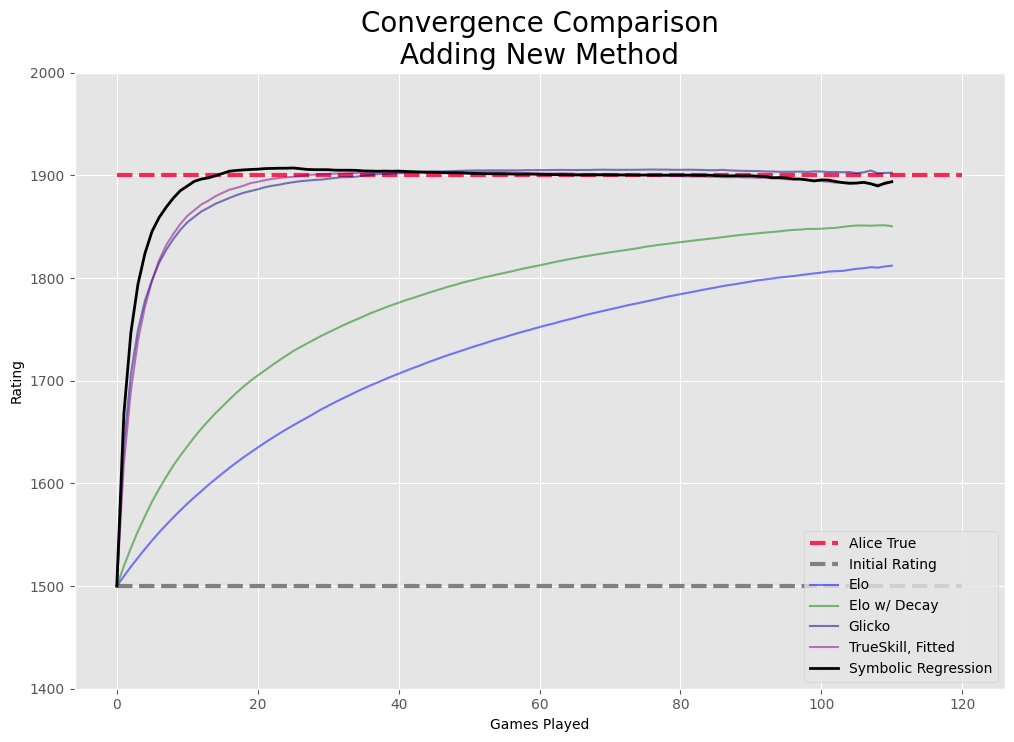

In [32]:

ratings = {
    'Alice':1900,
    'Bob':1700,
    'Chelsea':1500,
    'Dimitri':1300,
    'Evelyn':1100
}



fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True)

# ax1 = axes[0]
ax.set_title('Convergence Comparison\nAdding New Method', fontsize=20)
ax.set_ylim(1400, 2000)
ax.hlines(ratings['Alice'], xmin=0, xmax=120, color=colors['Alice'],linewidth=3, linestyle='--',label='Alice True')
ax.hlines(1500, xmin=0, xmax=120, color='grey',linewidth=3, linestyle='--',label='Initial Rating')

ax.set_ylabel("Rating")

ax.plot(alice_elo.games_played, alice_elo.avg_rating, label='Elo', color='blue', alpha=0.5)
ax.plot(alice_elo_DK.games_played, alice_elo_DK.avg_rating, label='Elo w/ Decay', color='green', alpha=0.5)
ax.plot(alice_glicko.games_played, alice_glicko.avg_rating, label='Glicko', color='navy', alpha=0.5)
ax.plot(alice_TS_2.games_played, alice_TS_2.avg_rating, label='TrueSkill, Fitted', color='purple', alpha=0.5)
ax.plot(alice_atk.games_played, alice_atk.avg_rating, label='Symbolic Regression', color='black', lw=2, alpha=1)

ax.set_xlabel("Games Played")
# for test_num, test_data in dynamic_k.groupby('test_num'):
#     if test_num % 1000 == 0:
#         print("first_graph", test_num)
#     for player_name, player in test_data.groupby(['player']):
#         ax1.plot(player.games_played, player.rating, alpha=0.05, color=colors[player_name])

ax.legend()
plt.savefig('C://Users/Blake/Downloads/rating_systems_convergence_2.png', bbox_inches='tight')
plt.show()



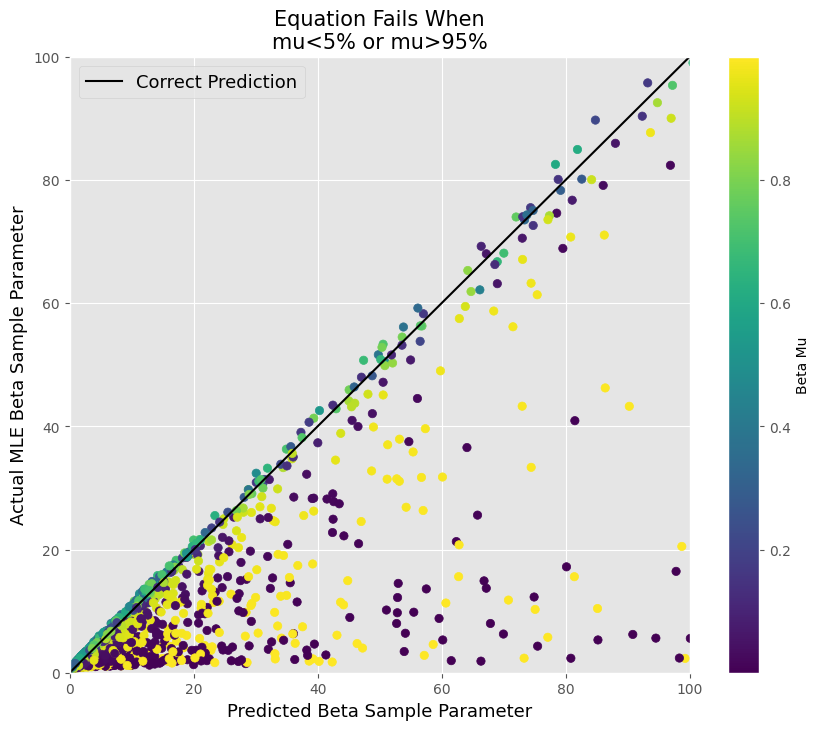

In [33]:

fig, ax = plt.subplots(figsize=(10,8))
plt.scatter(preds, y_copy, c=X[:,0])
plt.colorbar(label='Beta Mu')
x = np.linspace(0,100, 1000)
y = copy(x)
plt.plot(x, y, label='Correct Prediction', c='k')
plt.title("Equation Fails When\nmu<5% or mu>95%",fontsize=15)
ax.set_xlabel("Predicted Beta Sample Parameter",fontsize=13)
ax.set_ylabel("Actual MLE Beta Sample Parameter",fontsize=13)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.legend(fontsize=13)
plt.savefig('C://Users/Blake/Downloads/eq_failure.png')
plt.show()
